,Image,Class,SSIM,PSNR,MSE,RMSE
0,,french,0.487732,11.616236,3039.589615,55.132473
1,,light,0.431595,14.894836,2024.866776,44.998520
2,,french,0.429375,10.950735,2749.602783,52.436655
3,,french,0.423992,10.824034,2620.816650,51.193912
4,,french,0.422111,11.147681,2351.299866,48.490204
5,,espresso,0.414341,8.235340,4597.715881,67.806459
6,,light,0.411679,11.582143,4517.165649,67.209863
7,,light,0.407585,15.520231,1077.678177,32.828009
8,,espresso,0.352114,10.847209,1706.098526,41.304946
9,,green,0.303742,13.197890,2424.242172,49.236594

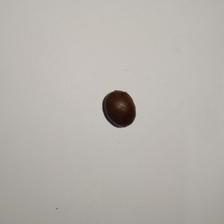
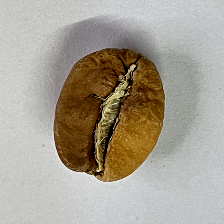
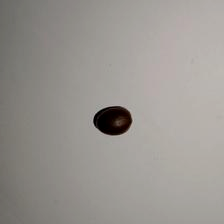
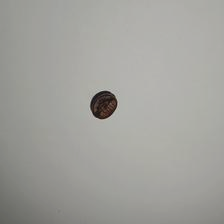
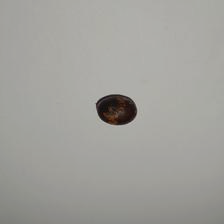
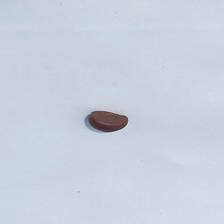
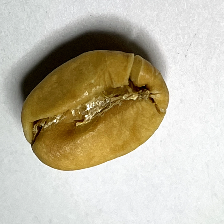
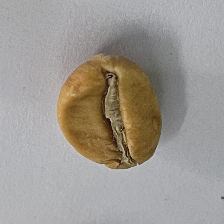
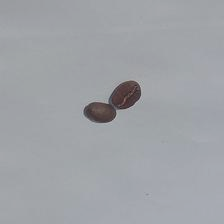
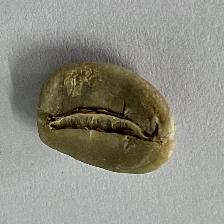

In [ ]:
import os
import random
import numpy as np
from PIL import Image
import pandas as pd
from base64 import b64encode
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import mean_squared_error
from IPython.display import HTML

def image_path_to_html(path):
    with open(path, "rb") as image_file:
        encoded_string = b64encode(image_file.read()).decode()
    img_html = f'<img src="data:image/jpeg;base64,{encoded_string}" width="36">'
    return img_html

def load_images_from_classes(base_path, num_images=10000):
    classes = [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]
    selected_images = []
    images_per_class = max(1, num_images // len(classes))

    for class_name in classes:
        class_dir = os.path.join(base_path, class_name)
        images = [os.path.join(class_dir, img) for img in os.listdir(class_dir) if img.endswith(('.png', '.jpg', '.jpeg'))]
        selected_images.extend([(img, class_name) for img in random.sample(images, min(images_per_class, len(images)))])

    random.shuffle(selected_images)
    return selected_images

def calculate_image_metrics(img_path, reference_img_path, target_size=(256, 256)):
    img = np.array(Image.open(img_path).convert('L').resize(target_size))
    ref_img = np.array(Image.open(reference_img_path).convert('L').resize(target_size))
    mse_val = mean_squared_error(ref_img, img)
    rmse_val = np.sqrt(mse_val)
    ssim_val = ssim(ref_img, img, data_range=img.max() - img.min())
    psnr_val = psnr(ref_img, img, data_range=img.max() - img.min())
    return ssim_val, psnr_val, mse_val, rmse_val

def find_top_ssim_images(images, reference_image_path, top_n=10):
    reference_img = np.array(Image.open(reference_image_path).convert('L').resize((256, 256)))
    ssim_scores = []

    for _ in range(top_n):
        img_path, class_name = random.choice(images)
        ssim_val, psnr_val, mse_val, rmse_val = calculate_image_metrics(img_path, reference_image_path)
        if ssim_val == 1.0:
            continue
        ssim_scores.append((img_path, class_name, ssim_val, psnr_val, mse_val, rmse_val))

    top_images = sorted(ssim_scores, key=lambda x: x[2], reverse=True)[:top_n]
    return top_images

def display_top_images(top_images):
    df = pd.DataFrame(top_images, columns=['Image', 'Class', 'SSIM', 'PSNR', 'MSE', 'RMSE'])
    df['Image'] = df['Image'].apply(image_path_to_html)
    display(HTML(df.to_html(escape=False)))

base_path = "dataset/split/valid"
images = load_images_from_classes(base_path)
reference_image_path = images[0][0]
top_images = find_top_ssim_images(images, reference_image_path)
display_top_images(top_images)
